### Import& Hyperparameters

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

#for importing audio
import glob
import os 
import IPython
import IPython.display as ipd


#For reading music
import librosa as lb
import librosa.display


# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [2]:
# Hyperparameters

# question: 93ms is higher than the n_ftt
num_epochs = 5
num_classes = 10
batch_size = 100
adam_lr = 0.005
test_size = 0.61
n_mels = 80
framePerInput = 15
DATA_PATH = "Data"

window = [23, 46, 92]  # ms
hop_size = 10  # ms

### From Data Load to Input of Model

In [3]:
#load the data paths
list_of_songs= glob.glob( os.path.join(DATA_PATH, '**', '*.wav'), recursive=True)
#data: list of wav sound files 
data = [lb.load(song) for song in list_of_songs]


#to access sample rate of the ith song data[i][1]


In [4]:
print("number of songs",len(list_of_songs))
n_song= len(list_of_songs)

number of songs 17


In [5]:
print(data[0][1])
#access to sample rate

22050


In [6]:
# loading training images

#TODO Calculate max_frame frmo data and get ri
#TODO: frequences from 27.5 to 16kHz
#normalize each freq band to zero mean and unit variange
train_img = []

for y in data :
    tab=[]
    for i in range(len(window)):
    #transform the audio into a melspectogram 
    #ADDED: window size 
        sr_y= y[1]
        window_size_i= (0.001* window[i])* sr_y
        hop_length=int(hop_size*0.001*sr_y)
        
        melspectogram=lb.feature.melspectrogram(y=y[0],hop_length=hop_length,sr=sr_y,win_length= int(window_size_i),n_mels=n_mels)
        # take the log instead of the db 
        img= np.log(melspectogram)
        # 603: x axis, 128, y avis
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        tab.append(img)
    train_img.append(tab)


<ipython-input-6-9bfe7a71c076>:19: RuntimeWarning: divide by zero encountered in log
  img= np.log(melspectogram)


In [7]:

print("number of spectograms "+str(len(train_img)))
print(len(train_img[0]))
print(train_img[0][0].shape)
print ("dimensions of a spectogram :(n_mels, #frames)" )
print("#frames=(1+len(y)/hop_length)")


number of spectograms 17
3
(80, 1404)
dimensions of a spectogram :(n_mels, #frames)
#frames=(1+len(y)/hop_length)


In [8]:
#pad the np array of a song so the number of frames can be a multiple of framPerInput(15)
def padToCloset(n_song):
    spectograms=np.array(train_img[n_song])
    print("before",spectograms.shape)
    n_frame= train_img[n_song][0].shape[1]
    frames_to_add = 0 if (n_frame %framePerInput==0) else framePerInput-(n_frame%framePerInput)
    return np.pad(spectograms,( (0,0),(0,0), (0,int(frames_to_add))))

In [9]:
print(padToCloset(0).shape)

before (3, 80, 1404)
(3, 80, 1410)


In [10]:
n_frames_song= np.empty(n_song,dtype=object)
def songToInputs():
    res=[]
    n=0
    for i in range(n_song):
        print("song",i,"--------------")
        spec=padToCloset(i)
        print("after",padToCloset(i).shape)
        n_frame= spec.shape[2]
        n_frames_song[i]=n
        n+=n_frame

        for k in range(int(n_frame/15)):
            res.append( spec [:,:,15*k:15*(k+1) ])
        print(len(res))

    return np.array(res)


In [11]:
    print (n_frames_song.shape)

(17,)


In [12]:
train_img_f=songToInputs()

song 0 --------------
before (3, 80, 1404)
before (3, 80, 1404)
after (3, 80, 1410)
94
song 1 --------------
before (3, 80, 3021)
before (3, 80, 3021)
after (3, 80, 3030)
296
song 2 --------------
before (3, 80, 2005)
before (3, 80, 2005)
after (3, 80, 2010)
430
song 3 --------------
before (3, 80, 1474)
before (3, 80, 1474)
after (3, 80, 1485)
529
song 4 --------------
before (3, 80, 602)
before (3, 80, 602)
after (3, 80, 615)
570
song 5 --------------
before (3, 80, 1504)
before (3, 80, 1504)
after (3, 80, 1515)
671
song 6 --------------
before (3, 80, 1504)
before (3, 80, 1504)
after (3, 80, 1515)
772
song 7 --------------
before (3, 80, 1474)
before (3, 80, 1474)
after (3, 80, 1485)
871
song 8 --------------
before (3, 80, 1103)
before (3, 80, 1103)
after (3, 80, 1110)
945
song 9 --------------
before (3, 80, 1504)
before (3, 80, 1504)
after (3, 80, 1515)
1046
song 10 --------------
before (3, 80, 1504)
before (3, 80, 1504)
after (3, 80, 1515)
1147
song 11 --------------
before (3,

In [13]:
n_frames=n_frames_song/15
print(n_frames)

[0.0 94.0 296.0 430.0 529.0 570.0 671.0 772.0 871.0 945.0 1046.0 1147.0
 1251.0 1335.0 1382.0 1428.0 1529.0]


In [14]:
print(train_img_f.shape)

(1630, 3, 80, 15)


(3, 80, 15)


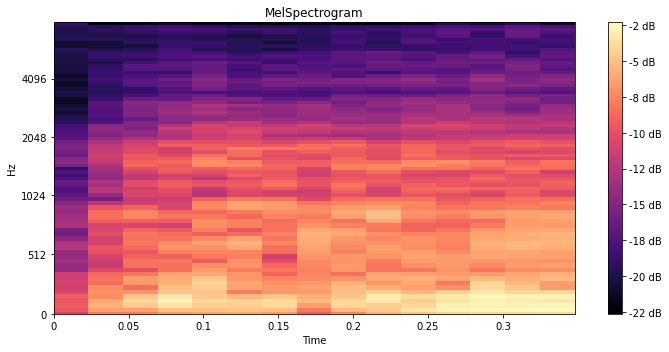

(3, 80, 15)


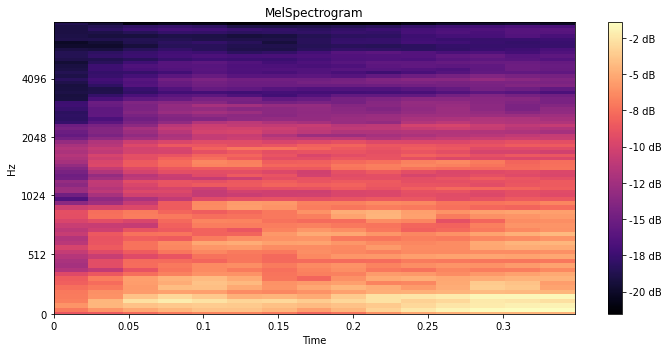

(3, 80, 15)


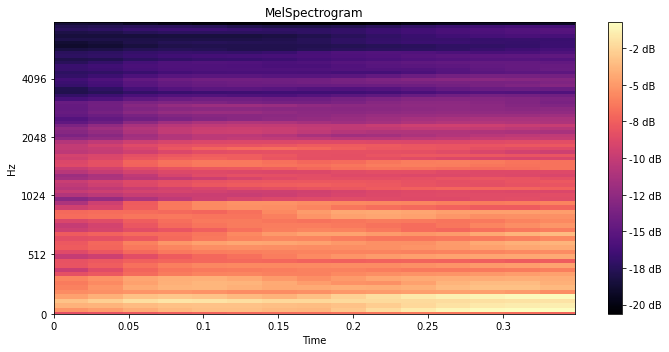

In [15]:
#QUESTION: DO ALL FRAMES HAVE THE SAME LENGTH? DOES THE WINDOW AFFECT THE FRAME LENGTH?

#visualize an image 
plt.figure(figsize=(10, 5))
print(train_img_f[0].shape)
librosa.display.specshow(train_img_f[0][0], x_axis='time', y_axis='mel', sr=22050, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
print(train_img_f[1].shape)
librosa.display.specshow(train_img_f[0][1], x_axis='time', y_axis='mel', sr=22050, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
print(train_img_f[2].shape)
librosa.display.specshow(train_img_f[0][2], x_axis='time', y_axis='mel', sr=22050, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()


In [16]:
#load labels
n_inputs=train_img_f.shape[0]

In [17]:
# load labels
list_labels= glob.glob( os.path.join(DATA_PATH, '**', '*.csv'), recursive=True)
label = [pd.read_csv(label,header=None) for label in list_labels ]


In [18]:
def returnNameFile(s):
    return (os.path.splitext(os.path.basename(s))[0])

In [19]:
def labelMatchSongs() :
    for i in range(len(list_of_songs)):
        if (returnNameFile(list_of_songs[i])!=returnNameFile(list_labels[i])): return False
    return True
    

In [20]:
#Check labels & songs match
print ("label match check :", labelMatchSongs())
print("__________________________")
print("Manuel Check")
print("num :labels",len(list_labels))
print("num: songs",len(list_of_songs))
for i in range(len(list_of_songs)):
    print(returnNameFile(list_of_songs[i]))
    print(returnNameFile(list_labels[i]))
    print("------")



label match check : True
__________________________
Manuel Check
num :labels 17
num: songs 17
cello1
cello1
------
clarinet1
clarinet1
------
classic2
classic2
------
classic3
classic3
------
distguit1
distguit1
------
guitar2
guitar2
------
guitar3
guitar3
------
jazz2
jazz2
------
jazz3
jazz3
------
piano1
piano1
------
pop1
pop1
------
rock1
rock1
------
sax1
sax1
------
synthbass1
synthbass1
------
techno2
techno2
------
trumpet1
trumpet1
------
violin2
violin2
------


In [21]:
#get duration of song 
print (lb.get_duration(filename=list_of_songs[1]))

30.14092970521542


In [22]:
#Question

#Gives the appropriate frame of a time t relative to the sound number : 
#the second < duration_song
#fromFourierToSecond 
def fromSecToFrame ( song_number, second ):
    song_length=lb.get_duration(filename=list_of_songs[1])
    if (second> song_length):
        raise Exception ("invalid label, offset after the end of the song")
    #float(hop_length)/sr # units of seconds
    duration_frame= float(hop_length)/ data[song_number][1]
    return int(second/duration_frame)



In [23]:
def fromSecToInputN (song_number,second):
    n_frame= fromSecToFrame(song_number,second)
    n_input=int(n_frame/15)
    return n_frames[song_number]+n_input

    

In [24]:
#2d List : label_fin[n_song]: contains the frames where an onset occurs

label_f=np.zeros((n_inputs,1))
for i in range(n_song):
    print("-----------------------------------")
    print ("song ",i," / ", n_song)
    for j in range (len(label[i].iloc[0])):
        print ("label ",j+1," / ",len(label[i].iloc[0]), " sec",label[i].iloc[0][j], 
               " frame ",fromSecToFrame(i,label[i].iloc[0][j]),
        "input number", fromSecToInputN(i,label[i].iloc[0][j]))
        label_f[int(fromSecToInputN(i,label[i].iloc[0][j]))]=int(1)
print(label_f.shape)

-----------------------------------
song  0  /  17
label  1  /  61  sec 1.030398445092487  frame  103 input number 6.0
label  2  /  61  sec 1.244830864352864  frame  124 input number 8.0
label  3  /  61  sec 1.447968636355489  frame  145 input number 9.0
label  4  /  61  sec 1.6493181758503017  frame  165 input number 11.0
label  5  /  61  sec 1.8599925678986091  frame  186 input number 12.0
label  6  /  61  sec 2.0318635343516918  frame  203 input number 13.0
label  7  /  61  sec 2.223852774336837  frame  222 input number 14.0
label  8  /  61  sec 2.436360321867013  frame  244 input number 16.0
label  9  /  61  sec 2.637936859963229  frame  264 input number 17.0
label  10  /  61  sec 2.820386715420705  frame  282 input number 18.0
label  11  /  61  sec 3.0169445635958416  frame  302 input number 20.0
label  12  /  61  sec 3.196406744925583  frame  320 input number 21.0
label  13  /  61  sec 3.408664682760565  frame  341 input number 22.0
label  14  /  61  sec 3.628446403719828  frame 

label  30  /  38  sec 14.08039232508989  frame  1411 input number 390.0
label  31  /  38  sec 14.91525944239333  frame  1494 input number 395.0
label  32  /  38  sec 15.35857297690651  frame  1539 input number 398.0
label  33  /  38  sec 15.801521141485061  frame  1583 input number 401.0
label  34  /  38  sec 16.24841536821194  frame  1628 input number 404.0
label  35  /  38  sec 16.710817365450662  frame  1674 input number 407.0
label  36  /  38  sec 17.10010461870558  frame  1713 input number 410.0
label  37  /  38  sec 17.591674851329838  frame  1763 input number 413.0
label  38  /  38  sec 18.50395776692014  frame  1854 input number 419.0
-----------------------------------
song  3  /  17
label  1  /  4  sec 5.897157460911977  frame  591 input number 469.0
label  2  /  4  sec 7.601762554715831  frame  761 input number 480.0
label  3  /  4  sec 7.967168734787066  frame  798 input number 483.0
label  4  /  4  sec 10.53065880744656  frame  1055 input number 500.0
---------------------

label  5  /  47  sec 3.6815790244975495  frame  368 input number 796.0
label  6  /  47  sec 3.8811101162542254  frame  388 input number 797.0
label  7  /  47  sec 4.065566630038581  frame  407 input number 799.0
label  8  /  47  sec 4.471147749017251  frame  448 input number 801.0
label  9  /  47  sec 4.6499766250666745  frame  466 input number 803.0
label  10  /  47  sec 4.8400937535565  frame  485 input number 804.0
label  11  /  47  sec 5.247418523712684  frame  525 input number 807.0
label  12  /  47  sec 5.414686271211367  frame  542 input number 808.0
label  13  /  47  sec 5.8314820534023655  frame  584 input number 810.0
label  14  /  47  sec 6.006664186794528  frame  602 input number 812.0
label  15  /  47  sec 6.251316113678717  frame  626 input number 813.0
label  16  /  47  sec 6.430971408399287  frame  644 input number 814.0
label  17  /  47  sec 6.6097493910565674  frame  662 input number 816.0
label  18  /  47  sec 6.816720880073047  frame  683 input number 817.0
label  1

label  13  /  27  sec 5.3015018319993015  frame  531 input number 1081.0
label  14  /  27  sec 6.0398848815540145  frame  605 input number 1086.0
label  15  /  27  sec 6.771211570486886  frame  678 input number 1091.0
label  16  /  27  sec 7.500315799845967  frame  751 input number 1096.0
label  17  /  27  sec 7.8675884047929765  frame  788 input number 1098.0
label  18  /  27  sec 8.251031636454421  frame  826 input number 1101.0
label  19  /  27  sec 8.60661406685056  frame  862 input number 1103.0
label  20  /  27  sec 8.977847586070652  frame  899 input number 1105.0
label  21  /  27  sec 9.724607568759065  frame  974 input number 1110.0
label  22  /  27  sec 10.707358572990358  frame  1073 input number 1117.0
label  23  /  27  sec 11.159725337331158  frame  1118 input number 1120.0
label  24  /  27  sec 11.3131307336516  frame  1133 input number 1121.0
label  25  /  27  sec 11.86994367541189  frame  1189 input number 1125.0
label  26  /  27  sec 12.21625215808966  frame  1224 inpu

label  6  /  56  sec 0.596463638179442  frame  59 input number 1385.0
label  7  /  56  sec 0.6878890893880683  frame  68 input number 1386.0
label  8  /  56  sec 0.9057485315723152  frame  90 input number 1388.0
label  9  /  56  sec 1.012847692841321  frame  101 input number 1388.0
label  10  /  56  sec 1.121272857621325  frame  112 input number 1389.0
label  11  /  56  sec 1.220553802552117  frame  122 input number 1390.0
label  12  /  56  sec 1.332944698055184  frame  133 input number 1390.0
label  13  /  56  sec 1.443619748314202  frame  144 input number 1391.0
label  14  /  56  sec 1.5425948766750848  frame  154 input number 1392.0
label  15  /  56  sec 1.7607539635011091  frame  176 input number 1393.0
label  16  /  56  sec 1.871395442480221  frame  187 input number 1394.0
label  17  /  56  sec 1.976544840808025  frame  198 input number 1395.0
label  18  /  56  sec 2.0783367166614006  frame  208 input number 1395.0
label  19  /  56  sec 2.190490377325223  frame  219 input number 1

label  11  /  73  sec 1.856911123769319  frame  186 input number 1541.0
label  12  /  73  sec 2.098696987215676  frame  210 input number 1543.0
label  13  /  73  sec 2.5138163111022385  frame  251 input number 1545.0
label  14  /  73  sec 2.6028938159555506  frame  260 input number 1546.0
label  15  /  73  sec 2.731199761116622  frame  273 input number 1547.0
label  16  /  73  sec 2.852263945514506  frame  285 input number 1548.0
label  17  /  73  sec 2.9919733555752903  frame  299 input number 1548.0
label  18  /  73  sec 3.092936900690157  frame  309 input number 1549.0
label  19  /  73  sec 3.639159852849335  frame  364 input number 1553.0
label  20  /  73  sec 4.331476023416632  frame  434 input number 1557.0
label  21  /  73  sec 4.790307243750153  frame  480 input number 1561.0
label  22  /  73  sec 4.893634853634463  frame  490 input number 1561.0
label  23  /  73  sec 5.023007595331754  frame  503 input number 1562.0
label  24  /  73  sec 5.126838654696804  frame  513 input num

### Validation Set 


In [25]:
# create validation set
print( train_img_f.shape)
print(label_f.shape)

#should add a test set 
train_x, val_x, train_y, val_y = train_test_split(train_img_f, label_f, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape) #add shapes 

(1630, 3, 80, 15)
(1630, 1)


(((1467, 3, 80, 15), (1467, 1)), ((163, 3, 80, 15), (163, 1)))

In [26]:
# converting training images into torch format
train_x  = torch.from_numpy(train_x).float()
#.type(torch.LongTensor)


# converting the target into torch format
train_y = torch.from_numpy(train_y).float()
#.type(torch.LongTensor)


# shape of training data
train_x.shape, train_y.shape

(torch.Size([1467, 3, 80, 15]), torch.Size([1467, 1]))

In [27]:
#check for nan
print(train_x)


tensor([[[[-10.4274, -10.8810,  -9.5674,  ..., -11.1315,  -9.6026,  -8.6859],
          [-10.3103, -12.4197,  -9.5694,  ..., -10.5694, -10.2342,  -9.0787],
          [-11.1161, -13.1166, -10.8174,  ..., -12.0322, -12.1173, -10.8340],
          ...,
          [-18.9614, -19.0442, -18.6044,  ..., -16.0439, -15.4865, -16.1556],
          [-19.5983, -19.1950, -19.0216,  ..., -15.8432, -16.3661, -15.9078],
          [-20.4816, -20.8459, -20.1058,  ..., -16.9837, -17.5486, -16.7257]],

         [[ -9.3467,  -9.3315,  -8.9880,  ...,  -9.7862,  -8.3141,  -8.1384],
          [ -9.5940, -10.1906,  -9.3352,  ..., -10.0883,  -9.6274,  -8.9616],
          [-10.9556, -11.0667, -10.9529,  ..., -11.9915, -11.7877, -11.0673],
          ...,
          [-18.2802, -18.1170, -17.8399,  ..., -15.2082, -15.0078, -15.1685],
          [-18.6524, -18.5256, -18.2750,  ..., -15.2800, -15.3834, -15.3643],
          [-19.7692, -19.9192, -19.3409,  ..., -16.3925, -16.4378, -16.2612]],

         [[ -8.3417,  -8.4342,

In [28]:
print(train_y)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])


In [29]:
# converting validation images into torch format
val_x  = torch.from_numpy(val_x).float()

# converting the target into torch format
val_y = torch.from_numpy(val_y).float()

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([163, 3, 80, 15]), torch.Size([163, 1]))

In [30]:
print(val_x)

tensor([[[[-3.6682e+00, -3.2675e+00, -4.4691e+00,  ..., -2.6633e+00,
           -2.3104e+00, -3.1461e+00],
          [-1.5619e+00, -1.4712e+00, -1.6703e+00,  ..., -2.9308e-01,
           -1.1337e-01, -3.5231e-01],
          [-7.1886e-01, -1.1771e+00, -8.2808e-01,  ...,  3.4313e-01,
            3.4214e-01,  1.6936e-01],
          ...,
          [-1.8151e+01, -1.8759e+01, -1.8306e+01,  ..., -1.8130e+01,
           -1.8546e+01, -1.8064e+01],
          [-1.8612e+01, -1.8952e+01, -1.8333e+01,  ..., -1.8051e+01,
           -1.8527e+01, -1.8975e+01],
          [-2.0321e+01, -2.0484e+01, -2.0456e+01,  ..., -2.0601e+01,
           -2.0346e+01, -2.1146e+01]],

         [[-3.8454e+00, -3.4176e+00, -3.6415e+00,  ..., -3.7194e+00,
           -3.8334e+00, -3.6326e+00],
          [-1.2487e+00, -1.1583e+00, -1.1784e+00,  ...,  4.7641e-02,
            2.7556e-01,  2.5573e-01],
          [ 1.0531e-01,  1.6068e-02,  3.5429e-01,  ...,  1.2461e+00,
            1.3094e+00,  1.3401e+00],
          ...,
     

In [31]:
print(val_y)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
      

### Model 

In [32]:
#define the architecture 

class convNet(nn.Module):
    """
    copies the neural net used in a paper.
    "Improved musical onset detection with Convolutional Neural Networks".
    src: https://ieeexplore.ieee.org/document/6854953
    """

    def __init__(self):

        super(convNet, self).__init__()
        # model
        self.conv1 = nn.Conv2d(3, 10, (3, 7))
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(1120, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 1)


    def forward(self, x, istraining=False, minibatch=1):
 #       print(x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x.float())), (3, 1))

     #   print(x)
 #       print("after max pool2D 1 :",x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (3, 1))
  #      print("after max pool2D 2 :",x.shape)
        #Add the minibatch in the training loop 
        x = F.dropout(x.view(x.shape[0], -1), training=istraining)
   #     print("after dropout1  :",x.shape)
        x=self.fc1(x)
        x=F.relu(x)
    #    print("after relu 1  :",x.shape)

        
        x = F.dropout(x, training=istraining)
     #   print("after dropout2  :",x.shape)
        
        x=F.relu(self.fc2(x))
      #  print("after relu 1  :",x.shape)


        x = F.dropout(x, training=istraining)

       # print("after dropout3  :",x.shape)
        x=self.fc3(x)
        #print("fc3 works")
        x=F.sigmoid(x)
#        print("nan count = ", torch.sum(torch.isnan(x)))

        return x

""""
        
      #  x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)

        x = self.linear_layers(x)
        return x
"""

'"\n        \n      #  x = self.cnn_layers(x)\n        x = x.view(x.size(0), -1)\n\n        x = self.linear_layers(x)\n        return x\n'

In [33]:
# defining the model
model = convNet()
# defining the optimizer

#TODO : tune the parameter
optimizer = Adam(model.parameters(), lr=adam_lr)

# defining the loss function
criterion = nn.MSELoss()

#question 
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)


convNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 7), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1120, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=1, bias=True)
)


In [34]:
#train the model 
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    x_train[x_train == -float("Inf")] = -100
    x_val[x_val == -float("Inf")] = -100

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
  #  print(x_train)
    output_train = model(x_train)
#    print("output train",output_train)
    output_val = model(x_val)
#    print("output train",output_val)

#   print("nan count output train= ", torch.sum(torch.isnan(output_train)))
   # print("output train",output_train.shape)
   # print("output_val", y_train.shape)
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    
    train_losses.append(loss_train)
    val_losses.append(loss_val)
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [44]:
# defining the number of epochs
n_epochs = 100
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)


Epoch :  1 	 loss : tensor(0.1527, grad_fn=<MseLossBackward>)
Epoch :  3 	 loss : tensor(0.1575, grad_fn=<MseLossBackward>)
Epoch :  5 	 loss : tensor(0.1573, grad_fn=<MseLossBackward>)
Epoch :  7 	 loss : tensor(0.1540, grad_fn=<MseLossBackward>)
Epoch :  9 	 loss : tensor(0.1516, grad_fn=<MseLossBackward>)
Epoch :  11 	 loss : tensor(0.1495, grad_fn=<MseLossBackward>)
Epoch :  13 	 loss : tensor(0.1670, grad_fn=<MseLossBackward>)
Epoch :  15 	 loss : tensor(0.1539, grad_fn=<MseLossBackward>)
Epoch :  17 	 loss : tensor(0.1621, grad_fn=<MseLossBackward>)
Epoch :  19 	 loss : tensor(0.1550, grad_fn=<MseLossBackward>)
Epoch :  21 	 loss : tensor(0.1533, grad_fn=<MseLossBackward>)
Epoch :  23 	 loss : tensor(0.1687, grad_fn=<MseLossBackward>)
Epoch :  25 	 loss : tensor(0.1641, grad_fn=<MseLossBackward>)
Epoch :  27 	 loss : tensor(0.1519, grad_fn=<MseLossBackward>)
Epoch :  29 	 loss : tensor(0.1609, grad_fn=<MseLossBackward>)
Epoch :  31 	 loss : tensor(0.1834, grad_fn=<MseLossBackward

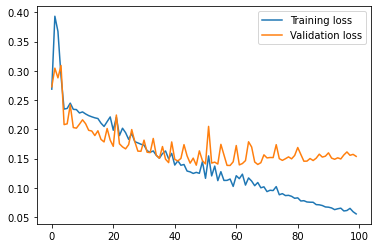

In [38]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [41]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.6932515337423313